In [1]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

data_path = r"C:\Users\HP\Documents\GitHub\3D-3D_Image_Registration\SE000003"

# List all files in the directory
files = os.listdir(data_path)
print(files)


['CT000000', 'CT000001', 'CT000002', 'CT000003', 'CT000004', 'CT000005', 'CT000006', 'CT000007', 'CT000008', 'CT000009', 'CT000010', 'CT000011', 'CT000012', 'CT000013', 'CT000014', 'CT000015', 'CT000016', 'CT000017', 'CT000018', 'CT000019', 'CT000020', 'CT000021', 'CT000022', 'CT000023', 'CT000024', 'CT000025', 'CT000026', 'CT000027', 'CT000028', 'CT000029', 'CT000030', 'CT000031', 'CT000032', 'CT000033', 'CT000034', 'CT000035', 'CT000036', 'CT000037', 'CT000038', 'CT000039', 'CT000040', 'CT000041', 'CT000042', 'CT000043', 'CT000044', 'CT000045', 'CT000046', 'CT000047', 'CT000048', 'CT000049', 'CT000050', 'CT000051', 'CT000052', 'CT000053', 'CT000054', 'CT000055', 'CT000056', 'CT000057', 'CT000058', 'CT000059', 'CT000060', 'CT000061', 'CT000062', 'CT000063', 'CT000064', 'CT000065', 'CT000066', 'CT000067', 'CT000068', 'CT000069', 'CT000070', 'CT000071', 'CT000072', 'CT000073', 'CT000074', 'CT000075', 'CT000076', 'CT000077', 'CT000078', 'CT000079', 'CT000080', 'CT000081', 'CT000082', 'CT

______________________

C:\Users\HP\AppData\Local\Temp\ipykernel_18568\3531002651.py:9: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate


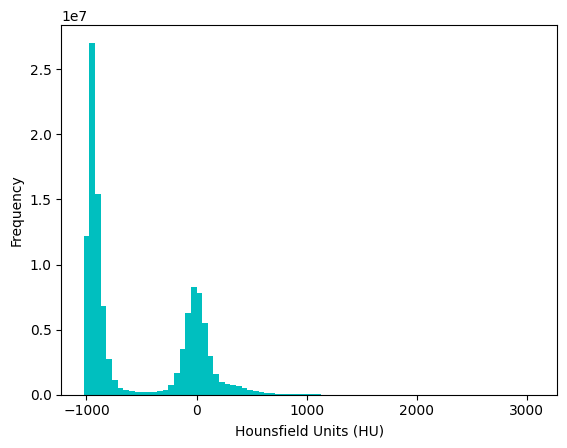

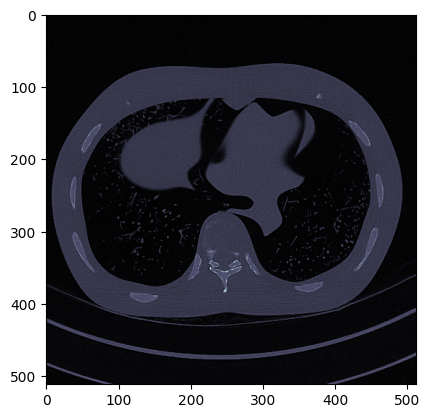

In [2]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import os
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops
from scipy.ndimage.interpolation import rotate

# create a function to load the files
def load_scan(path):
    slices = [pydicom.dcmread(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    return slices

# create a function to get the pixel values
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
    image += np.int16(intercept)
    return np.array(image, dtype=np.int16)

# load the scans
first_patient = load_scan(data_path)
first_patient_pixels = get_pixels_hu(first_patient)

# visualize
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.bone)
plt.show()


________________________________________

Patient ID: REMOVED
Modality: CT
Image Size: 512 x 512


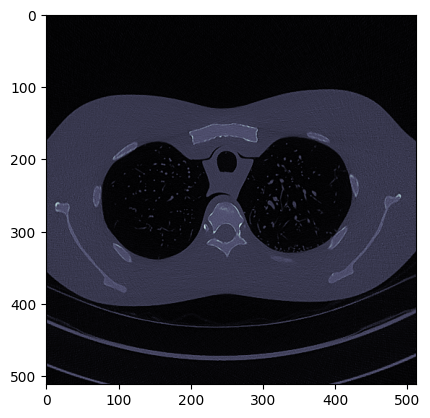

In [3]:
import cv2

# Adjust this to point to one specific image file
image_path = os.path.join(data_path, "CT000000")

# Read DICOM file
ds = pydicom.dcmread(image_path)

# Print some attributes
print(f"Patient ID: {ds.PatientID}")
print(f"Modality: {ds.Modality}")
print(f"Image Size: {ds.Rows} x {ds.Columns}")

# Preprocessing
image = ds.pixel_array  # Get pixel data
image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)  # Normalize pixel values between 0 and 255

# Show the image
import matplotlib.pyplot as plt
plt.imshow(image, cmap=plt.cm.bone)
plt.show()

_________________________

In [4]:
import pyvista as pv
import SimpleITK as sitk
import numpy as np
import os
import matplotlib.pyplot as plt

def load_dicom_series(directory_path):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(directory_path)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()
    return image

def display_images(image):
    # Convert the SimpleITK image to a numpy array
    image_array = sitk.GetArrayFromImage(image)
    
    # Normalize to 0-255
    image_array = ((image_array - image_array.min()) * (1/(image_array.max() - image_array.min()) * 255)).astype('uint8')
    
    # Create the spatial reference
    grid = pv.UniformGrid()

    # Set the dimensions 
    grid.dimensions = image_array.shape
    grid.origin = (0, 0, 0)  # The bottom left corner of the data set
    grid.spacing = (1, 1, 1)  # These are the cell sizes along each axis

    # Add the data values to the cell data
    grid.point_data["values"] = image_array.flatten(order="F")  # Flatten the array!

    # Now plot the grid!
    grid.plot(show_edges=True)

# Paths to the DICOM directories
fixed_image_path = r"C:\Users\HP\Documents\GitHub\3D-3D_Image_Registration\SE000003"
moving_image_path = r"C:\Users\HP\Documents\GitHub\3D-3D_Image_Registration\SE000003"

# Load the DICOM images
fixed_image = load_dicom_series(fixed_image_path)
moving_image = load_dicom_series(moving_image_path)

# Display the images
display_images(fixed_image)
display_images(moving_image)

# Apply the transformation
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMeanSquares()
registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
registration_method.SetInterpolator(sitk.sitkLinear)

initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler3DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

registration_method.SetInitialTransform(initial_transform, inPlace=False)
final_transform_v1 = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                                 sitk.Cast(moving_image, sitk.sitkFloat32))

# Resample the moving image onto the fixed image's grid
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(fixed_image);
resampler.SetTransform(final_transform_v1);
resampled_moving_image = resampler.Execute(moving_image)

# Display the images
display_images(fixed_image)
display_images(resampled_moving_image)


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyvista\core\grid.py:873: PyVistaDeprecationWarning: `UniformGrid` is deprecated. Use `ImageData` instead.
  warnings.warn(


Widget(value="<iframe src='http://localhost:65321/index.html?ui=P_0x1980f8a4850_0&reconnect=auto' style='width…

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyvista\core\grid.py:873: PyVistaDeprecationWarning: `UniformGrid` is deprecated. Use `ImageData` instead.
  warnings.warn(


Widget(value="<iframe src='http://localhost:65321/index.html?ui=P_0x1981a13ecb0_1&reconnect=auto' style='width…

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyvista\core\grid.py:873: PyVistaDeprecationWarning: `UniformGrid` is deprecated. Use `ImageData` instead.
  warnings.warn(


Widget(value="<iframe src='http://localhost:65321/index.html?ui=P_0x1981a1a0430_2&reconnect=auto' style='width…

C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pyvista\core\grid.py:873: PyVistaDeprecationWarning: `UniformGrid` is deprecated. Use `ImageData` instead.
  warnings.warn(


Widget(value="<iframe src='http://localhost:65321/index.html?ui=P_0x1981a1a02e0_3&reconnect=auto' style='width…

In [ ]:
fixed_image_path = r"C:\Users\HP\Documents\GitHub\3D-3D_Image_Registration\SE000003"
moving_image_path = r"C:\Users\HP\Documents\GitHub\3D-3D_Image_Registration\SE000003"


In [ ]:
# import os
# import pydicom
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage import measure
# from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# def load_scan(path):
#     slices = [pydicom.dcmread(path + '/' + s) for s in os.listdir(path)]
#     slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
#     return slices

# def get_pixels_hu(slices):
#     image = np.stack([s.pixel_array for s in slices])
#     image = image.astype(np.int16)
#     image[image == -2000] = 0
#     intercept = slices[0].RescaleIntercept
#     slope = slices[0].RescaleSlope
#     if slope != 1:
#         image = slope * image.astype(np.float64)
#         image = image.astype(np.int16)
#     image += np.int16(intercept)
#     return np.array(image, dtype=np.int16)

# def plot_3d(image, threshold=-300):
#     p = image.transpose(2,1,0)
#     verts, faces, _, _ = measure.marching_cubes(p, threshold)
#     fig = plt.figure(figsize=(10, 10))
#     ax = fig.add_subplot(111, projection='3d')
#     mesh = Poly3DCollection(verts[faces], alpha=0.70)
#     face_color = [0.45, 0.45, 0.75]
#     mesh.set_facecolor(face_color)
#     ax.add_collection3d(mesh)
#     ax.set_xlim(0, p.shape[0])
#     ax.set_ylim(0, p.shape[1])
#     ax.set_zlim(0, p.shape[2])
#     plt.show()

# # Path to the DICOM directory
# path = r"C:\Users\HP\Documents\GitHub\3D-3D_Image_Registration\SE000003"  # Change this to your DICOM directory
# scan = load_scan(path)
# image = get_pixels_hu(scan)

# # Threshold: change this value to segment different parts of the image
# # For example, a threshold of 400 will segment the bones
# plot_3d(image, 400)
